In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import mixture


In [2]:
river_df = pd.read_csv('river_data.csv')

print(river_df.info())
print(river_df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923304 entries, 0 to 923303
Data columns (total 4 columns):
station_no     923304 non-null int64
date           923304 non-null object
discharge      923304 non-null float64
water_level    923304 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 28.2+ MB
None
         station_no      discharge    water_level
count  9.233040e+05  923304.000000  923304.000000
mean   6.482084e+06     416.427735    -484.957980
std    2.563108e+05     822.960147     592.618697
min    6.335020e+06    -999.000000    -999.000000
25%    6.335116e+06      10.530000    -999.000000
50%    6.335430e+06      58.292500    -999.000000
75%    6.435060e+06     433.239000     122.283250
max    6.935540e+06   11885.000000    1064.000000


In [3]:
river_df.date = pd.to_datetime(river_df.date, format='%Y-%m-%d')
river_df = river_df.set_index('date')
river_df = river_df.replace(-999.0, np.NaN)

river_df['year'] = river_df.index.to_series().dt.year
river_df['month'] = river_df.index.to_series().dt.month

In [5]:
stations = set(river_df.station_no.tolist())
print(stations)

if not os.path.exists('./stations'):
    os.makedirs('./stations')

water_levels = pd.DataFrame(columns=stations)

full_range = pd.date_range(river_df.index.min(), river_df.index.max()+pd.Timedelta(days=1)) #TODO add last day!
water_levels = water_levels.reindex(full_range, fill_value=np.NaN)

for s in stations:
    station_pd = river_df[river_df.station_no == s].copy()
    
    water_levels.loc[station_pd.index, s] = station_pd.water_level
    # station_pd = station_pd.drop('station_no', 1)
    station_pd['delta1'] = station_pd.water_level.shift(1) - station_pd.water_level
    station_pd['delta2'] = station_pd.water_level.shift(2) - station_pd.water_level
    station_pd['delta3'] = station_pd.water_level.shift(3) - station_pd.water_level
    station_pd.to_csv(f'./stations/station_{s}_river_data.csv')

{6935300, 6335621, 6935301, 6935302, 6335240, 6335115, 6335116, 6335500, 6935051, 6935053, 6935054, 6935055, 6935060, 6335125, 6335640, 6935460, 6335400, 6335020, 6335150, 6335410, 6336050, 6335030, 6335031, 6335032, 6335800, 6335170, 6335045, 6335301, 6335302, 6335304, 6335050, 6335180, 6935500, 6335310, 6335060, 6335190, 6335450, 6335070, 6335710, 6335200, 6335076, 6335460, 6335080, 6335081, 6335082, 6335083, 6935020, 6935145, 6935400, 6935401, 6335600, 6335601, 6335602, 6335603, 6335604, 6335730, 6335350, 6335351, 6336500, 6435060, 6935540, 6335100}


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
koln_df = river_df[river_df.station_no == 6335060]
print(koln_df.head())

dusseldorf_df = river_df[river_df.station_no == 6335050]

            station_no  discharge  water_level  year  month
date                                                       
1965-01-01     6335060     1240.0        110.0  1965      1
1965-01-02     6335060     1680.0        178.0  1965      1
1965-01-03     6335060     1820.0        200.0  1965      1
1965-01-04     6335060     1790.0        195.0  1965      1
1965-01-05     6335060     1800.0        196.0  1965      1


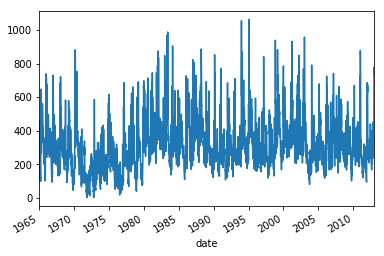

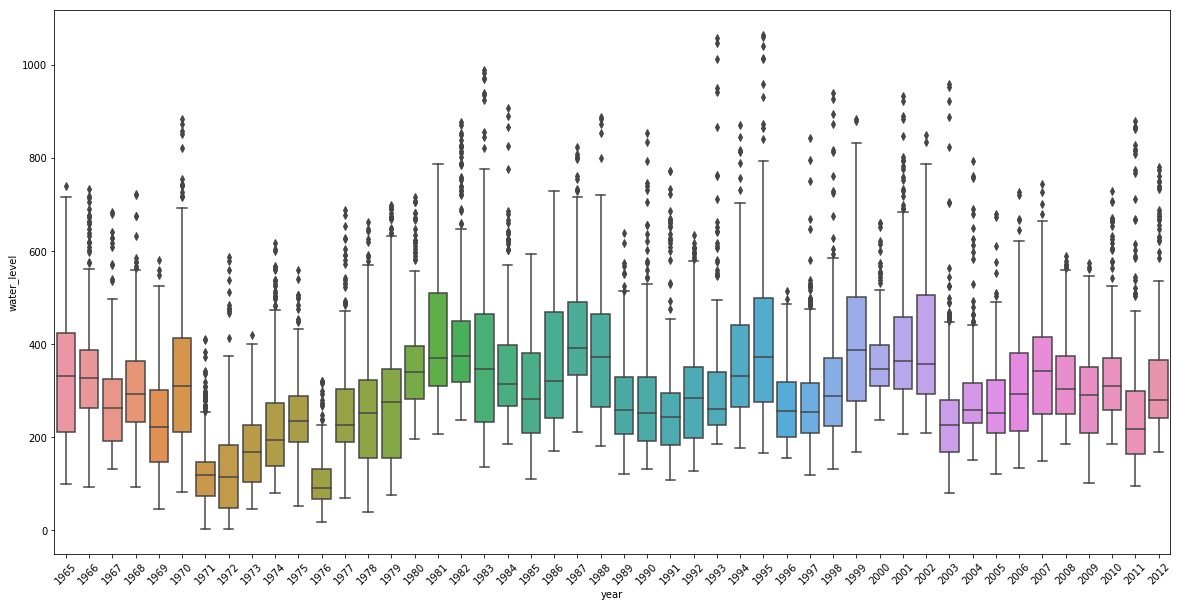

In [5]:
koln_df.water_level.plot()

# calculate boxplots depending on years, to check for a shift of 0-level
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)

sns.boxplot(y='water_level', x='year', data=koln_df)

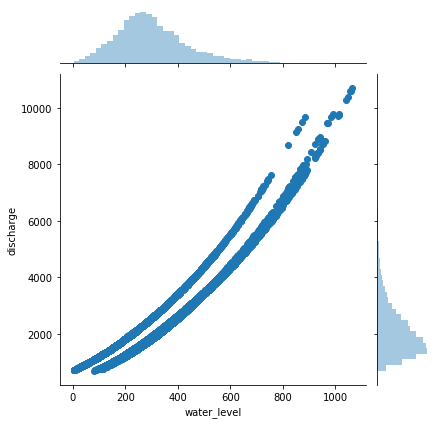

In [6]:
sns.jointplot(x=koln_df.water_level, y=koln_df.discharge)

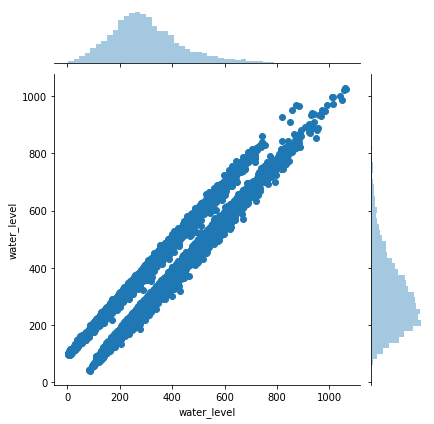

In [7]:
sns.jointplot(x=koln_df.water_level, y=dusseldorf_df.water_level)

[[333.80880772 304.29876948]
 [239.62683442 334.96934522]]


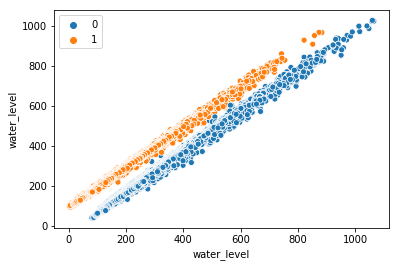

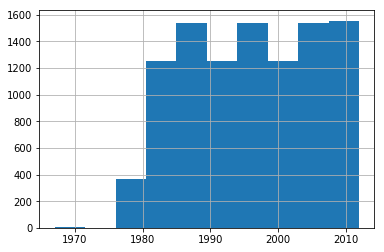

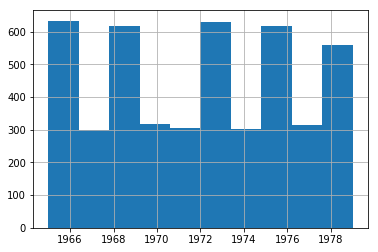

In [6]:
target = pd.concat((koln_df.water_level, dusseldorf_df.water_level), axis=1)
clustering = mixture.BayesianGaussianMixture(n_components=2,
                                        covariance_type='full').fit(target)

print(clustering.means_)
clusters = clustering.predict(target)
sns.scatterplot(x=koln_df.water_level, y=dusseldorf_df.water_level, hue=clusters)

plt.figure()
koln_df[clusters == 0].year.hist()
plt.figure()
koln_df[clusters == 1].year.hist()

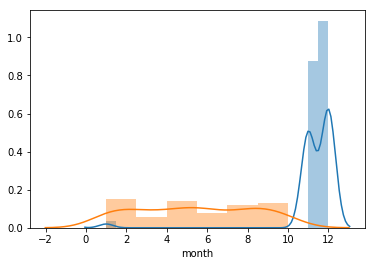

In [9]:
sns.distplot(koln_df[(clusters == 0) & (koln_df.year == 1979)].month)
sns.distplot(koln_df[(clusters == 1) & (koln_df.year == 1979)].month)

plt.show()

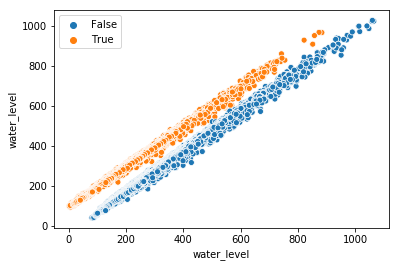

In [7]:
target_year = 1979
target_month = 11

old_level_dates = (koln_df.year < target_year) | ((koln_df.year == target_year) & (koln_df.month < target_month))
sns.scatterplot(x=koln_df.water_level, y=dusseldorf_df.water_level, hue=old_level_dates)


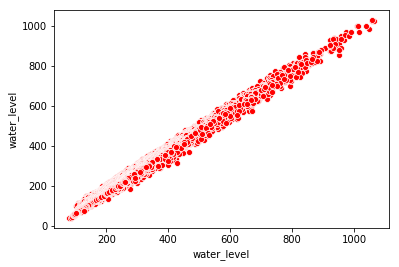

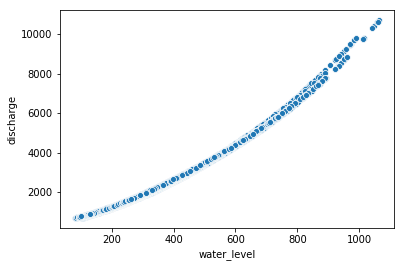

In [11]:
koln_df_fixed = koln_df.copy()

koln_df_fixed.loc[old_level_dates, 'water_level'] += 100

sns.scatterplot(x=koln_df_fixed.water_level, y=dusseldorf_df.water_level, color='red')

plt.figure()
sns.scatterplot(x=koln_df_fixed.water_level, y=koln_df_fixed.discharge)


koln_df_fixed['delta1'] = koln_df_fixed.water_level.shift(1) - koln_df_fixed.water_level
koln_df_fixed['delta2'] = koln_df_fixed.water_level.shift(2) - koln_df_fixed.water_level
koln_df_fixed['delta3'] = koln_df_fixed.water_level.shift(3) - koln_df_fixed.water_level

koln_df_fixed.to_csv(f'./stations/station_6335060_river_data.csv')

In [8]:
print('Fixing the river_data.csv')
old_level_dates = (river_df.year < target_year) | ((river_df.year == target_year) & (river_df.month < target_month))

river_df.loc[(river_df.station_no == 6335060) & old_level_dates, 'water_level'] += 100

river_df.to_csv('river_data_cologne_fixed.csv')

Fixing the river_data.csv


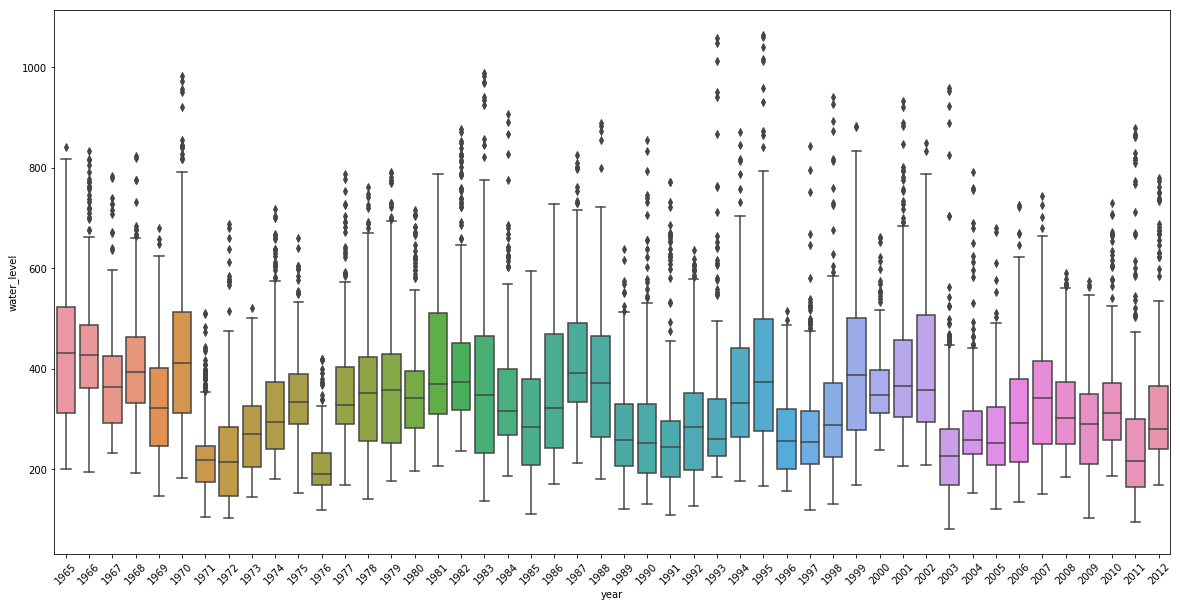

In [32]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.boxplot(y='water_level', x='year', data=koln_df_fixed)